In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.4.5-bin-hadoop2.7')
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('AIT614').getOrCreate()

In [3]:
from pyspark.sql.types import IntegerType, StringType, BooleanType, FloatType, StructType, StructField, DoubleType

In [4]:
structsch = [StructField('instant', IntegerType(), True),
             StructField('dteday', StringType(), True),
             StructField('season', IntegerType(), True),
             StructField('yr', IntegerType(), True),
             StructField('mnth', IntegerType(), True),
             StructField('hr', IntegerType(), True),
             StructField('holiday', IntegerType(), True),
             StructField('weekday', IntegerType(), True),
             StructField('workingday', IntegerType(), True),
             StructField('weathersit', IntegerType(), True),
             StructField('temp', FloatType(), True),
             StructField('atemp', FloatType(), True),
             StructField('hum', FloatType(), True),
             StructField('windspeed', FloatType(), True),
             StructField('casual', IntegerType(), True),
             StructField('registered', IntegerType(), True),
             StructField('cnt', IntegerType(), True)]

In [5]:
myschema = StructType(fields = structsch)
df = spark.read.csv('hour.csv', schema = myschema, header = True)
df.printSchema()

root
 |-- instant: integer (nullable = true)
 |-- dteday: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- atemp: float (nullable = true)
 |-- hum: float (nullable = true)
 |-- windspeed: float (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)



In [6]:
from pyspark.sql.functions import to_date

In [7]:
newdf = df.withColumn('dteday', to_date('dteday'))
newdf.printSchema()

root
 |-- instant: integer (nullable = true)
 |-- dteday: date (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: float (nullable = true)
 |-- atemp: float (nullable = true)
 |-- hum: float (nullable = true)
 |-- windspeed: float (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)



In [8]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [9]:
asmblr = VectorAssembler(inputCols=newdf.columns[2:17], outputCol="myfeatures")
col_vect = asmblr.transform(newdf).select("myfeatures")
corrmatrix = Correlation.corr(col_vect,"myfeatures").collect()[0][0]
matrix = corrmatrix.toArray().tolist()

In [10]:
print(matrix)

[[1.0, -0.010742486207830642, 0.8303858922042, -0.006116900866181412, -0.00958452586919802, -0.0023353497250265453, 0.013743101747069972, -0.01452355213911341, 0.31202523866985576, 0.3193798098683391, 0.15062474438557363, -0.1497727509876121, 0.12020644735002411, 0.17422563340237332, 0.17805573098268168], [-0.010742486207830642, 1.0, -0.010472928816710813, -0.003867004949332627, 0.006691616608159507, -0.004484851244104465, -0.002196005414265235, -0.019156853236269963, 0.04091337925304558, 0.03922159704013151, -0.08354642120302026, -0.008739532969748236, 0.14277852832924165, 0.25368430980716933, 0.2504948988596516], [0.8303858922042, -0.010472928816710813, 1.0, -0.005771908829884764, 0.018430325232945105, 0.010400061080367347, -0.0034769217948620082, 0.005399521906100094, 0.20169149453442334, 0.20809613051515455, 0.1644114429147225, -0.13538632318894428, 0.06845730074875549, 0.12227296677307097, 0.12063776021315172], [-0.006116900866181412, -0.003867004949332627, -0.005771908829884764, 

In [11]:
from matplotlib import pyplot as plt

In [12]:
def plot_corr_matrix(corrs,atrbts,fino):
    figure=plt.figure(fino)
    axis=figure.add_subplot(111)
    axis.set_title("Correlation Matrix")
    axis.set_xticklabels(['']+atrbts)
    axis.set_yticklabels(['']+atrbts)
    caxis=axis.matshow(corrs,vmax=1,vmin=-1)
    figure.colorbar(caxis)
    plt.show()

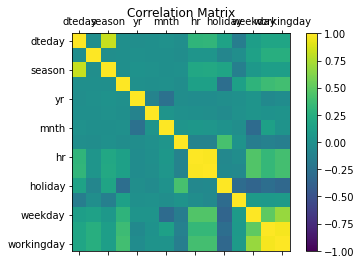

In [13]:
plot_corr_matrix(matrix, newdf.columns[1:17], 234)

In [14]:
newdf.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+--------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-----------------+------------------+------------------+
|summary|          instant|            season|                yr|              mnth|                hr|             holiday|          weekday|        workingday|        weathersit|               temp|             atemp|               hum|          windspeed|           casual|        registered|               cnt|
+-------+-----------------+------------------+------------------+------------------+------------------+--------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+-------------------+-----------------+------------------+------------------+
|  count|            17379|             17379|         

In [15]:
scrapdf = newdf.drop('instant','dteday')
scrapdf.columns

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt']

In [16]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

In [17]:
#--Feature Creation---
modelfeatures = VectorAssembler(inputCols=['season','yr','mnth','hr','holiday','weekday','workingday',
                                            'weathersit','temp','atemp','hum','windspeed','casual','registered'],
                                 outputCol= 'newcolumn')

In [18]:
op = modelfeatures.transform(scrapdf)
op.show(5)

+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+--------------------+
|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|casual|registered|cnt|           newcolumn|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+--------------------+
|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|      0.0|     3|        13| 16|[1.0,0.0,1.0,0.0,...|
|     1|  0|   1|  1|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|     8|        32| 40|[1.0,0.0,1.0,1.0,...|
|     1|  0|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|     5|        27| 32|[1.0,0.0,1.0,2.0,...|
|     1|  0|   1|  3|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0|     3|        10| 13|[1.0,0.0,1.0,3.0,...|
|     1|  0|   1|  4|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0|    

In [19]:
modeldf = op.select('newcolumn','cnt')
modeldf.show(5)

+--------------------+---+
|           newcolumn|cnt|
+--------------------+---+
|[1.0,0.0,1.0,0.0,...| 16|
|[1.0,0.0,1.0,1.0,...| 40|
|[1.0,0.0,1.0,2.0,...| 32|
|[1.0,0.0,1.0,3.0,...| 13|
|[1.0,0.0,1.0,4.0,...|  1|
+--------------------+---+
only showing top 5 rows



In [20]:
#------- Label Creation-----------
cntIndexer = StringIndexer(inputCol="cnt", outputCol="label")
labeldf = cntIndexer.fit(modeldf).transform(modeldf)
labeldf = labeldf.select('newcolumn','label')
labeldf.show(5)

+--------------------+-----+
|           newcolumn|label|
+--------------------+-----+
|[1.0,0.0,1.0,0.0,...| 13.0|
|[1.0,0.0,1.0,1.0,...| 37.0|
|[1.0,0.0,1.0,2.0,...| 28.0|
|[1.0,0.0,1.0,3.0,...| 12.0|
|[1.0,0.0,1.0,4.0,...|  7.0|
+--------------------+-----+
only showing top 5 rows



In [21]:
#Data Sampling
traindata2, validdata2 = labeldf.randomSplit([0.70,0.30], seed = 1234)

In [22]:
# Regression Models

In [23]:
#Linear Regression Model

In [24]:
lmmodel = LinearRegression(featuresCol='newcolumn',labelCol='label',maxIter=10,regParam=0.3,
                           elasticNetParam=0.8).fit(traindata2)
summary_train = lmmodel.summary

In [25]:
print("RMSE: %f" % summary_train.rootMeanSquaredError)

RMSE: 46.020719


In [26]:
print("R2: %f" % summary_train.r2)

R2: 0.930606


In [ ]:
lmpred = lmmodel.evaluate(validdata2)
lmpred.predictions.show(10)

In [ ]:
print("RMSE: %f" % lmpred.rootMeanSquaredError)

In [ ]:
print("R2: %f" % lmpred.r2)

In [ ]:
# Decision Tree Regression

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
dtree = DecisionTreeRegressor(featuresCol="newcolumn",labelCol="label")
dtmod = dtree.fit(traindata2)
dtpred = dtmod.transform(validdata2)
dtpred.select("prediction", "label", "newcolumn").show(5)

In [ ]:
dtevaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
dtevaluator2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
dtrmse = dtevaluator.evaluate(dtpred)
dtr2 = dtevaluator2.evaluate(dtpred)

In [ ]:
print("RMSE on test data = %g" % dtrmse)

In [ ]:
print("r2 on test data = %g" % dtr2)

In [ ]:
# Random Forest Regression Model to predict 'cnt'

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

In [ ]:
rfreg = RandomForestRegressor(featuresCol="newcolumn",labelCol="label", numTrees=500)
rfmod = rfreg.fit(traindata2)
rfpred = rfmod.transform(validdata2)

In [ ]:
rfpred.select("prediction", "label", "newcolumn").show(5)

In [ ]:
rfevaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rfevaluator2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
rfrmse = rfevaluator.evaluate(rfpred)
rfr2 = rfevaluator2.evaluate(rfpred)

In [ ]:
print("RMSE on test data = %g" % rfrmse)

In [ ]:
print("r2 on test data = %g" % rfr2)

In [ ]:
# Gradient Boosting Tree Regression

In [ ]:
from pyspark.ml.regression import GBTRegressor

In [ ]:
gradbt = GBTRegressor(featuresCol="newcolumn", labelCol="label" ,maxIter=10)
gbtmod = gradbt.fit(traindata2)
gbtpred = gbtmod.transform(validdata2)

In [ ]:
gbtpred.select("prediction", "label", "newcolumn").show(6)

In [ ]:
gbtevaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
gbtevaluator2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
gbtrmse = gbtevaluator.evaluate(gbtpred)
gbtr2 = gbtevaluator2.evaluate(gbtpred)

In [ ]:
print("RMSE on test data = %g" % gbtrmse)

In [ ]:
print("r2 on test data = %g" % gbtr2)